In [51]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(suppress=True) 

In [30]:
def MatrixInterpolation(x, y):
    # 计算插值矩阵
    n = len(x)
    M = np.zeros((n, n))
    M[:, 0] = y
    for j in range(1, n, 1): # 这里应该从列开始，一行一行的遍历：
        for i in range(j, n, 1):
            M[i, j] = ((M[i, j-1] - M[i-1, j-1])/(x[i] - x[i-j]))
    return M

# 获取离散点
# x = np.linspace(-5, 5, 11)
# y = 1 / (1 + x**2)
x = np.array([0.4, 0.55, 0.65, 0.8, 0.9, 1.05])
y = np.array([0.41075, 0.57815, 0.69675, 0.88811, 1.02652, 1.25382])
print(MatrixInterpolation(x, y))

[[0.41075    0.         0.         0.         0.         0.        ]
 [0.57815    1.116      0.         0.         0.         0.        ]
 [0.69675    1.186      0.28       0.         0.         0.        ]
 [0.88811    1.27573333 0.35893333 0.19733333 0.         0.        ]
 [1.02652    1.3841     0.43346667 0.21295238 0.0312381  0.        ]
 [1.25382    1.51533333 0.52493333 0.22866667 0.03142857 0.00029304]]


In [23]:
def divided_difference(x, y):
    return (
        None
        if len(x) == 0
        else y[0]
        if len(x) == 1
        else (divided_difference(x[1:], y[1:]) - divided_difference(x[:-1], y[:-1]))
        / (x[-1] - x[0])
    )


class CubicSpline:
    def __init__(self, x, y, dS):
        """
        Parameters
        ----------
        x : array_like
            一维数组，表示插值节点
        y : array_like
            一维数组，表示插值节点处的函数值
        dS : array_like
            长度为2的数组, 表示两个边界点处的导数值
        """
        assert len(x) == len(y), "x 和 y 的长度不一致"
        self.x = x
        self.y = y
        self.h = h = np.diff(x)
        self.n = n = len(h)

        A = np.eye(n + 1) * 2  # 系数矩阵
        D = np.zeros(n + 1)  # 右端向量

        A[0, 1] = 1
        A[n, n - 1] = 1
        for i in range(1, n, 1):
            A[i, (i + 1)] = h[i] / (h[i] + h[i - 1])  # lambda_i
            A[i, (i - 1)] = h[i - 1] / (h[i - 1] + h[i])  # mu_j

        for i in range(1, n, 1):
            D[i] = 6 * divided_difference(x[i - 1 : i + 2], y[i - 1 : i + 2])
        D[0] = 6 / h[0] * (divided_difference([x[0], x[1]], y[0:2]) - dS[0])
        D[n] = 6 / h[n - 1] * (dS[1] - divided_difference([x[n - 1], x[n]], y[-2:]))

        M = np.linalg.solve(A, D)
        self.M = M

    def __call__(self, t):
        x, h, M = self.x, self.h, self.M

        @np.vectorize
        def f(t):
            for i in range(self.n):
                if x[i] <= t <= x[i + 1]:
                    return (
                        M[i] * (x[i + 1] - t) ** 3 / (6 * h[i])
                        + M[i + 1] * (t - x[i]) ** 3 / (6 * h[i])
                        + (y[i] - (M[i] * h[i] ** 2) / 6) * (x[i + 1] - t) / h[i]
                        + (y[i + 1] - (M[i + 1] * h[i] ** 2) / 6) * (t - x[i]) / h[i]
                    )

        return f(t)

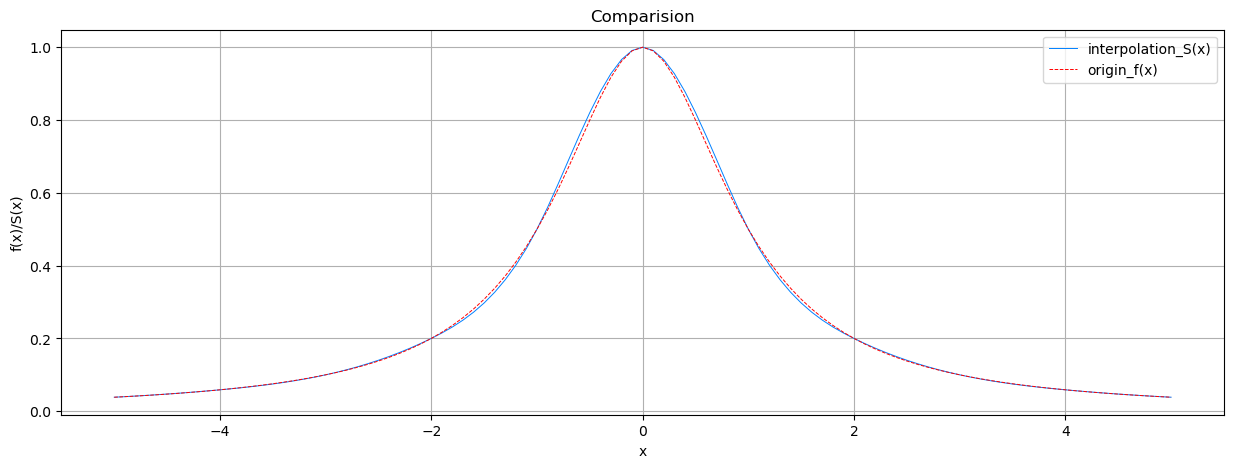

In [45]:
x_min, x_max = -5, 5
N = 11
f = lambda x: 1/(1 + x**2)

from sympy.abc import x
df = sp.diff(f(x))
dS = [df.subs(x, x_min), df.subs(x, x_max)]
x = np.linspace(x_min, x_max, N)
y = f(x)
g = CubicSpline(x, y, dS)

# 绘制函数图形
xs = np.linspace(-5, 5, 101)
plt.figure(figsize = (15, 5))
plt.plot(xs, g(xs), label = 'interpolation_S(x)', linewidth = 0.7, color = (0.0, 0.5, 1.0))
plt.plot(xs, f(xs), label = 'origin_f(x)', linewidth = 0.7, color = 'red', linestyle = '--')
plt.xlabel('x')
plt.ylabel('f(x)/S(x)')
plt.title('Comparision')
plt.legend()
plt.grid(True)
plt.show()


# 误差分析

In [1]:
error = pd.Series(index=xs, data=f(xs)-g(xs), name='error')
error.plot(figsize=(15, 5), title='Error', grid=True)
error.to_frame()

NameError: name 'pd' is not defined